In [3]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
import glob
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Number of images: 306
Number of labels: 456
Image shape: (12, 128, 128)
Number of channels: 12
Image dimensions (height x width): 128 x 128
Image metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 128, 'height': 128, 'count': 12, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
Label shape: (128, 128)
Unique values in label: [0 1]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


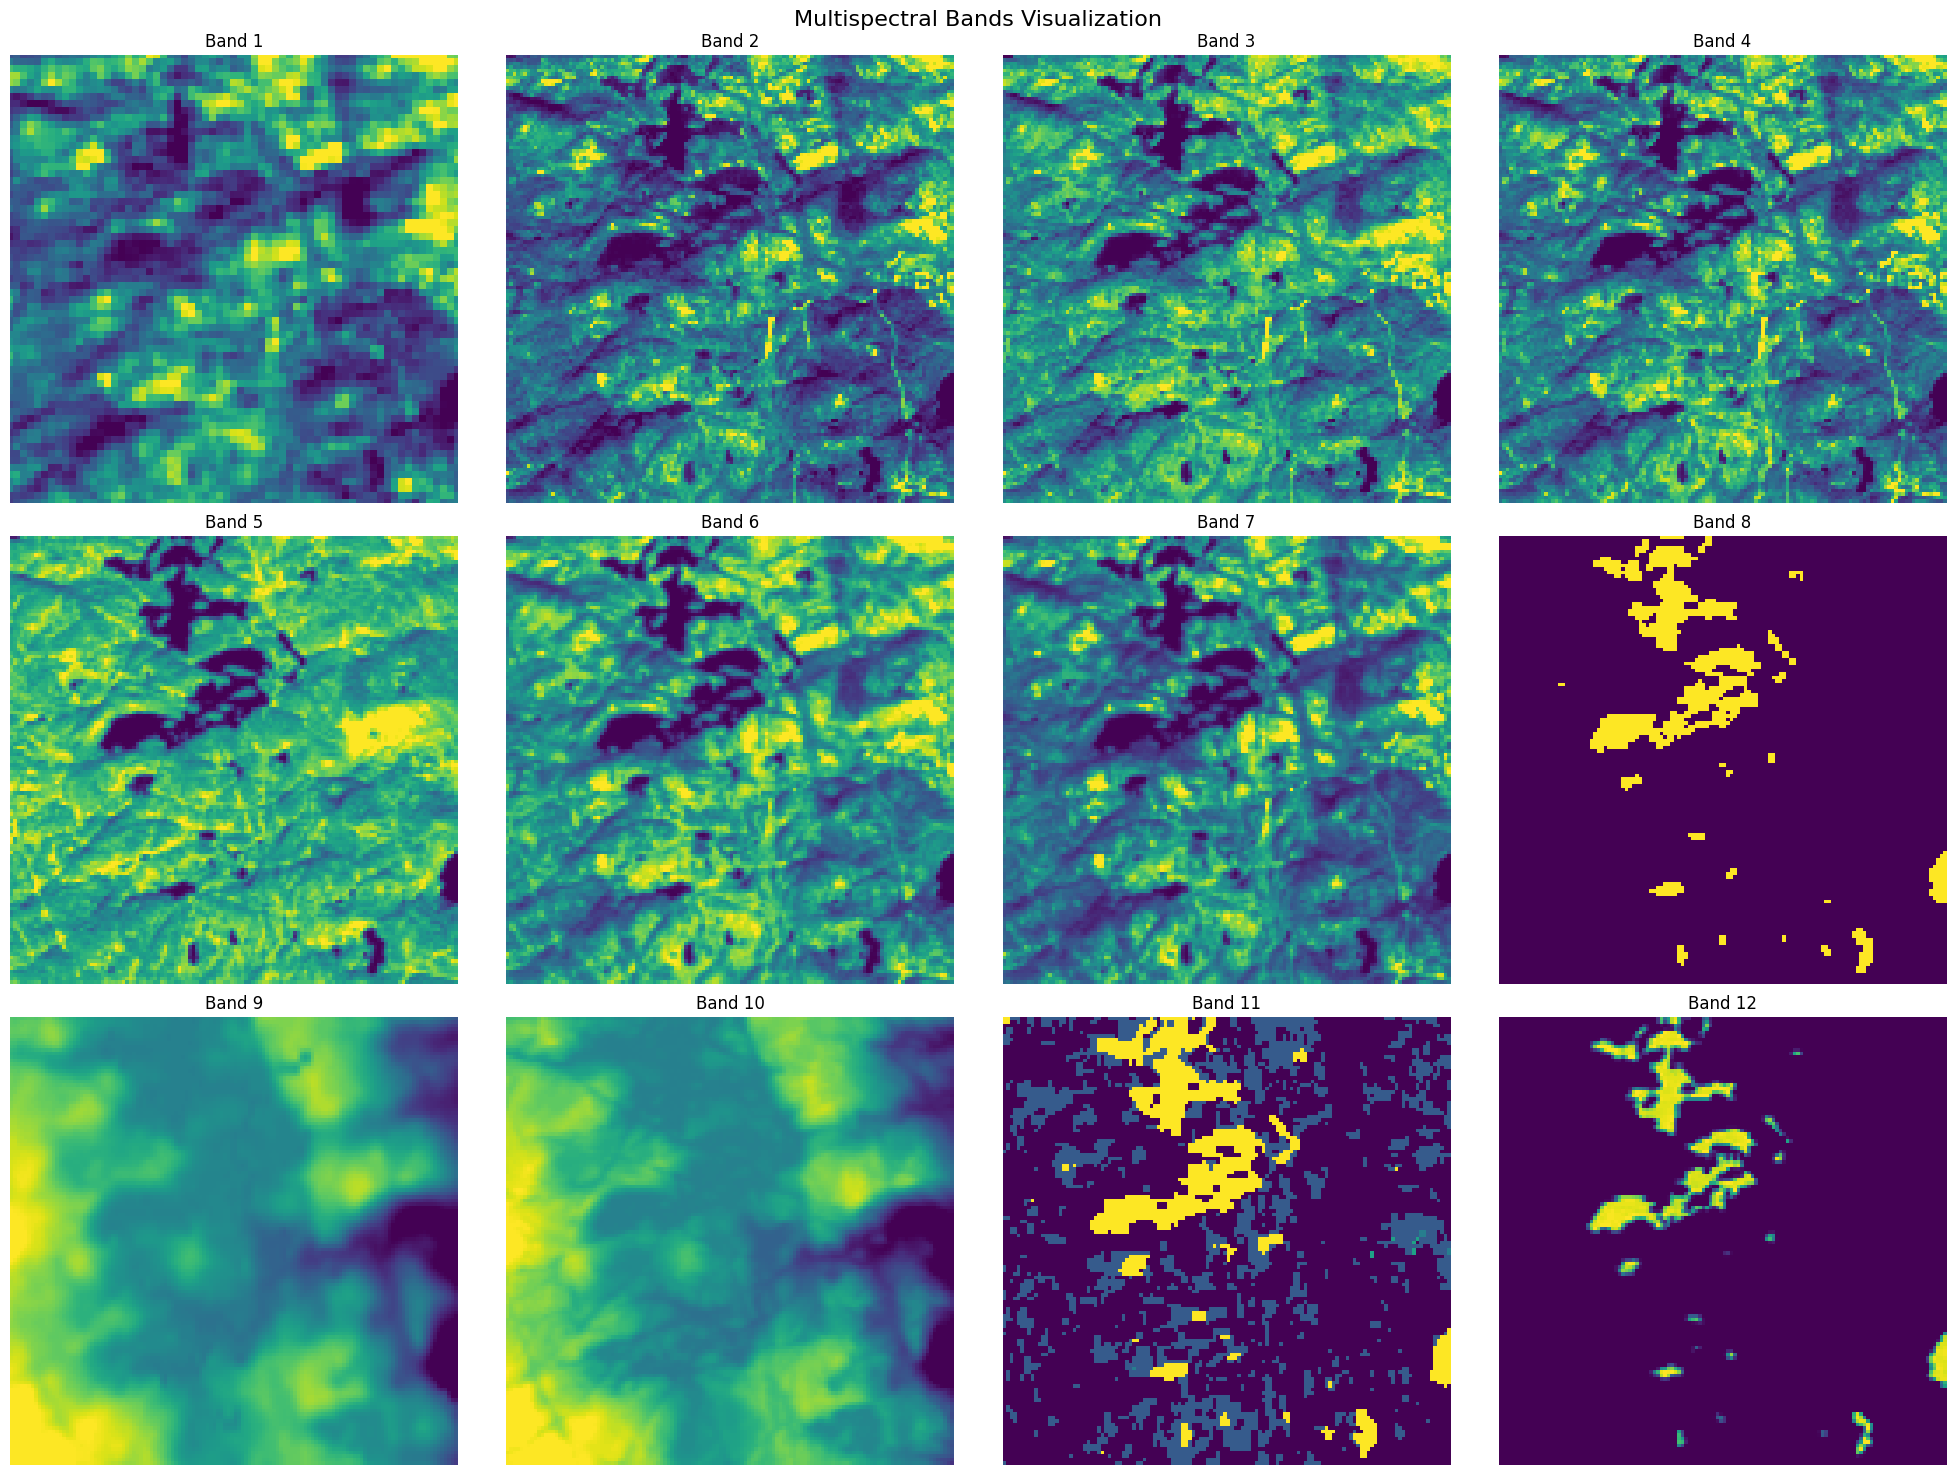

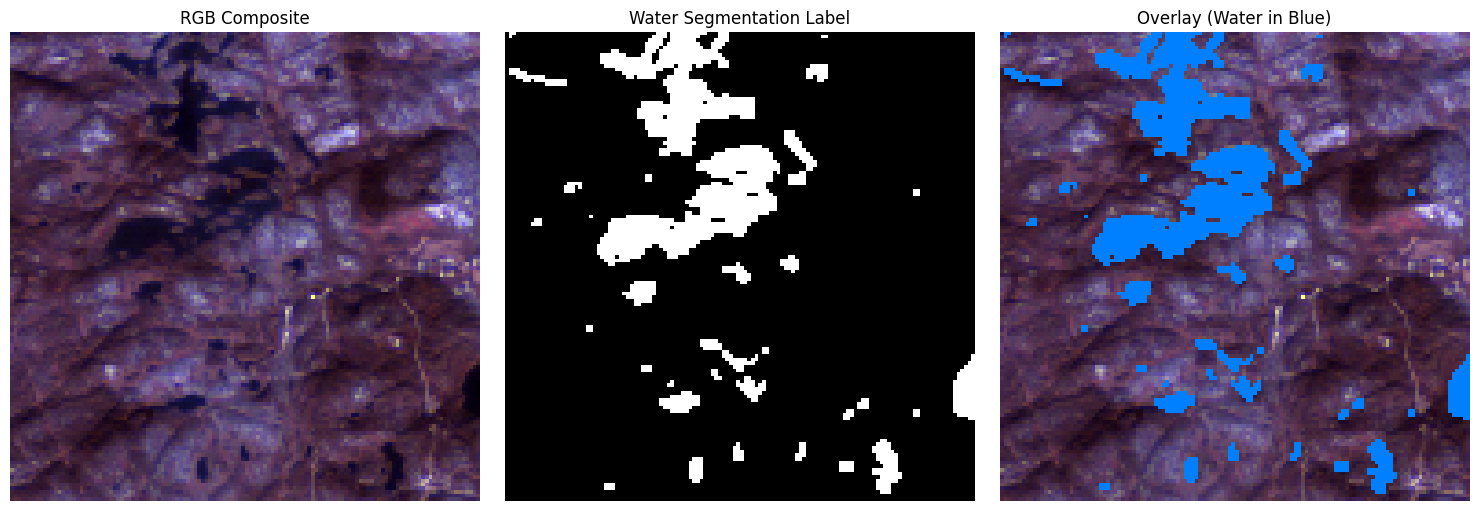

Analyzing labels:   0%|          | 0/456 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


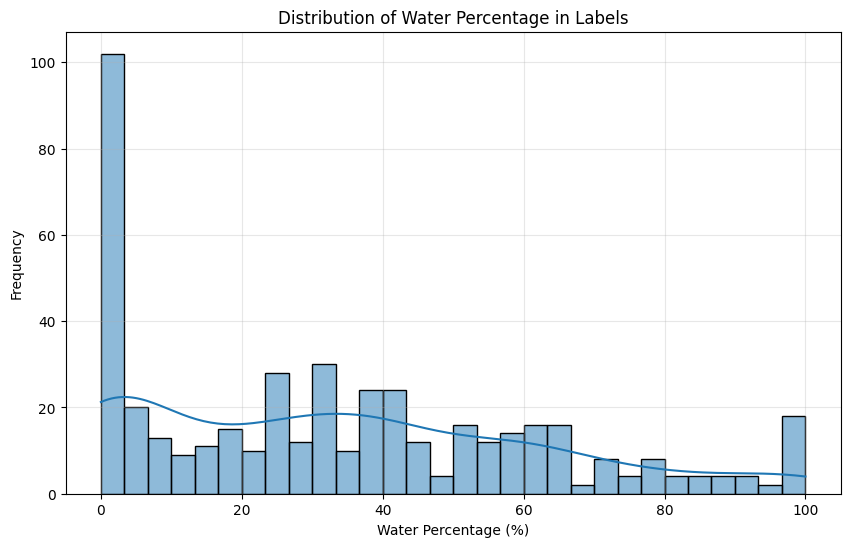

Water percentage summary statistics:
count    456.000000
mean      33.666604
std       28.610569
min        0.000000
25%        4.864502
50%       31.533813
75%       53.472900
max      100.000000
Name: water_percentage, dtype: float64


In [4]:
# Cell 2: Define paths and basic data exploration
# Define paths to your data
IMAGE_DIR = '/kaggle/input/waterdataset/data/images'
LABEL_DIR = '/kaggle/input/waterdataset/data/labels'

# List all image and label files
image_files = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.tif')))
label_files = sorted(glob.glob(os.path.join(LABEL_DIR, '*.png')))

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Cell 3: Analyze one example to understand the data structure
# Load and examine a sample image
sample_img_path = image_files[0]
with rasterio.open(sample_img_path) as src:
    sample_img = src.read()
    meta = src.meta
    
print(f"Image shape: {sample_img.shape}")
print(f"Number of channels: {sample_img.shape[0]}")
print(f"Image dimensions (height x width): {sample_img.shape[1]} x {sample_img.shape[2]}")
print(f"Image metadata: {meta}")

# Load and examine a sample label
sample_label_path = label_files[0]
sample_label = cv2.imread(sample_label_path, cv2.IMREAD_GRAYSCALE)
print(f"Label shape: {sample_label.shape}")
print(f"Unique values in label: {np.unique(sample_label)}")

# Cell 4: Visualize multispectral bands
def visualize_bands(img_path, figsize=(20, 15)):
    with rasterio.open(img_path) as src:
        img = src.read()
        
    n_bands = img.shape[0]
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(n_bands):
        # Normalize band for visualization
        band_data = img[i]
        vmin, vmax = np.percentile(band_data[band_data > 0], (2, 98))
        axes[i].imshow(band_data, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'Band {i+1}')
        axes[i].axis('off')
    
    # Hide empty subplots if any
    for i in range(n_bands, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.suptitle('Multispectral Bands Visualization', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize the sample image bands
visualize_bands(sample_img_path)

# Cell 5: Visualize the label and its overlay with RGB composite
def visualize_sample_with_label(img_path, label_path, figsize=(15, 5)):
    # Load image
    with rasterio.open(img_path) as src:
        img = src.read()
    
    # Create RGB composite using bands (assuming common band order)
    # This is an approximation - adjust based on your specific satellite data
    rgb_composite = np.zeros((img.shape[1], img.shape[2], 3))
    # For example, using bands 3,2,1 for RGB or other appropriate bands
    rgb_composite[:,:,0] = np.clip(img[2] / img[2].max(), 0, 1)  # Red
    rgb_composite[:,:,1] = np.clip(img[1] / img[1].max(), 0, 1)  # Green
    rgb_composite[:,:,2] = np.clip(img[0] / img[0].max(), 0, 1)  # Blue
    
    # Load label
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot RGB composite
    axes[0].imshow(rgb_composite)
    axes[0].set_title('RGB Composite')
    axes[0].axis('off')
    
    # Plot label
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title('Water Segmentation Label')
    axes[1].axis('off')
    
    # Plot overlay
    # Create a mask where water is present (assuming water is labeled as 1)
    water_mask = label > 0
    
    # Create an RGB image for the overlay
    overlay = rgb_composite.copy()
    overlay[water_mask, 0] = 0.0  # Reduce red
    overlay[water_mask, 1] = 0.5  # Reduce green
    overlay[water_mask, 2] = 1.0  # Enhance blue for water
    
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Water in Blue)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample image with its label
visualize_sample_with_label(sample_img_path, sample_label_path)

# Cell 6: Analyze the dataset distribution
def analyze_data_distribution():
    # Count water pixels in each label
    water_pixels_count = []
    total_pixels = []
    water_percentage = []
    
    for label_path in tqdm(label_files, desc="Analyzing labels"):
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        water_count = np.sum(label > 0)
        total = label.size
        water_pixels_count.append(water_count)
        total_pixels.append(total)
        water_percentage.append(water_count / total * 100)
    
    # Create a dataframe for easier analysis
    df = pd.DataFrame({
        'file': [os.path.basename(f) for f in label_files],
        'water_pixels': water_pixels_count,
        'total_pixels': total_pixels,
        'water_percentage': water_percentage
    })
    
    # Plot distribution of water percentages
    plt.figure(figsize=(10, 6))
    sns.histplot(df['water_percentage'], bins=30, kde=True)
    plt.title('Distribution of Water Percentage in Labels')
    plt.xlabel('Water Percentage (%)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Print summary statistics
    print("Water percentage summary statistics:")
    print(df['water_percentage'].describe())
    
    return df

# Analyze data distribution
distribution_df = analyze_data_distribution()

Successfully matched 306 image-label pairs
Train set: 214 pairs
Validation set: 46 pairs
Test set: 46 pairs


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-5-1fd2e57782b5>:99: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),
<ipython-input-5-1fd2e57782b5>:101: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWar

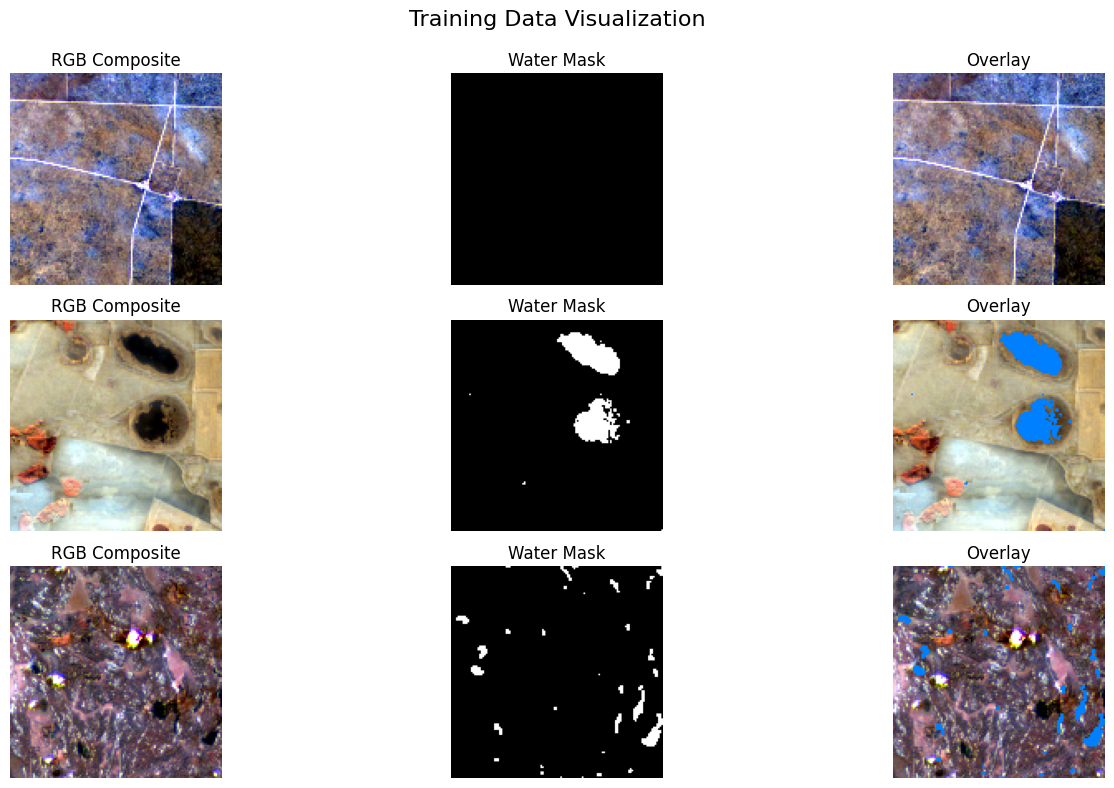

In [5]:
# Cell 7: Create custom dataset class for multispectral imagery
class MultispectralDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None, normalize=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.normalize = normalize
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load multispectral image
        with rasterio.open(self.image_paths[idx]) as src:
            image = src.read().astype(np.float32)  # [C, H, W]
        
        # Normalize each band individually using percentile-based normalization
        if self.normalize:
            for i in range(image.shape[0]):
                band = image[i]
                # Skip normalization if band is empty
                if np.max(band) - np.min(band) > 0:
                    # Use percentiles to avoid outliers
                    p_low, p_high = np.percentile(band[band > 0], (1, 99))
                    band = np.clip(band, p_low, p_high)
                    band = (band - p_low) / (p_high - p_low + 1e-8)
                    image[i] = band
        
        # Load label (mask)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = (label > 0).astype(np.float32)  # Binarize the mask
        
        # Apply any transformations
        if self.transform:
            # Convert to numpy format expected by transforms [H, W, C]
            image_transformed = np.transpose(image, (1, 2, 0))
            augmented = self.transform(image=image_transformed, mask=label)
            image = np.transpose(augmented['image'], (2, 0, 1))  # Back to [C, H, W]
            label = augmented['mask']
        
        # Convert to tensors
        image_tensor = torch.from_numpy(image)
        label_tensor = torch.from_numpy(label).unsqueeze(0)  # Add channel dimension [1, H, W]
        
        return image_tensor, label_tensor

# Cell 8: Split data into train, validation, and test sets
def create_splits(image_files, label_files, test_size=0.15, val_size=0.15, random_state=42):
    # Make sure image and label files are matched properly
    image_basenames = [os.path.basename(f).split('.')[0] for f in image_files]
    label_basenames = [os.path.basename(f).split('.')[0] for f in label_files]
    
    # Create a dataframe for matching
    df = pd.DataFrame({
        'image_path': image_files,
        'image_basename': image_basenames
    })
    
    df_labels = pd.DataFrame({
        'label_path': label_files,
        'label_basename': label_basenames
    })
    
    # Match images with their labels
    df = df.merge(df_labels, left_on='image_basename', right_on='label_basename', how='inner')
    print(f"Successfully matched {len(df)} image-label pairs")
    
    # Split into train+val and test
    train_val_indices, test_indices = train_test_split(
        range(len(df)), test_size=test_size, random_state=random_state
    )
    
    # Split train+val into train and val
    relative_val_size = val_size / (1 - test_size)
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=relative_val_size, random_state=random_state
    )
    
    # Create splits
    train_df = df.iloc[train_indices].reset_index(drop=True)
    val_df = df.iloc[val_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    print(f"Train set: {len(train_df)} pairs")
    print(f"Validation set: {len(val_df)} pairs")
    print(f"Test set: {len(test_df)} pairs")
    
    return train_df, val_df, test_df

# Split the data
train_df, val_df, test_df = create_splits(image_files, label_files)

# Cell 9: Data augmentation with albumin
import albumentations as A

# Define transformations for training
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.2),
])

# No transformations for validation and testing - just normalization
val_transform = None

# Create datasets
train_dataset = MultispectralDataset(
    train_df['image_path'].tolist(),
    train_df['label_path'].tolist(),
    transform=train_transform
)

val_dataset = MultispectralDataset(
    val_df['image_path'].tolist(),
    val_df['label_path'].tolist(),
    transform=val_transform
)

test_dataset = MultispectralDataset(
    test_df['image_path'].tolist(),
    test_df['label_path'].tolist(),
    transform=val_transform
)

# Create data loaders
batch_size = 4  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Visualize a batch of data to verify the loader works correctly
def visualize_batch(dataloader, figsize=(15, 8)):
    # Get a batch of data
    images, masks = next(iter(dataloader))
    
    # Move to numpy for visualization
    images = images.numpy()
    masks = masks.numpy()
    
    # Plot a few samples
    n_samples = min(3, images.shape[0])
    fig, axes = plt.subplots(n_samples, 3, figsize=figsize)
    
    for i in range(n_samples):
        # Create RGB composite for visualization (adjust bands based on your data)
        rgb = np.zeros((images.shape[2], images.shape[3], 3))
        rgb[:,:,0] = np.clip(images[i,2], 0, 1)  # Red - adjust band index as needed
        rgb[:,:,1] = np.clip(images[i,1], 0, 1)  # Green
        rgb[:,:,2] = np.clip(images[i,0], 0, 1)  # Blue
        
        # Plot RGB composite
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title('RGB Composite')
        axes[i, 0].axis('off')
        
        # Plot mask
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[i, 1].set_title('Water Mask')
        axes[i, 1].axis('off')
        
        # Plot RGB with mask overlay
        overlay = rgb.copy()
        mask_bool = masks[i, 0] > 0.5
        overlay[mask_bool, 0] = 0.0  # Reduce red
        overlay[mask_bool, 1] = 0.5  # Reduce green
        overlay[mask_bool, 2] = 1.0  # Enhance blue for water
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Training Data Visualization', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize a batch from the training loader
visualize_batch(train_loader)

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

Successfully loaded and adapted pretrained model from Hugging Face
Starting model training...


Epoch 1 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 1/30
Train Loss: 0.5962, IoU: 0.3849, F1: 0.5154
Val Loss: 0.4933, IoU: 0.4213, F1: 0.5603
New best model saved with IoU: 0.4213


Epoch 2 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 2/30
Train Loss: 0.4436, IoU: 0.5132, F1: 0.6435
Val Loss: 0.3693, IoU: 0.4938, F1: 0.6162
New best model saved with IoU: 0.4938


Epoch 3 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 3/30
Train Loss: 0.3575, IoU: 0.5838, F1: 0.7128
Val Loss: 0.3306, IoU: 0.5675, F1: 0.6946
New best model saved with IoU: 0.5675


Epoch 4 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 4/30
Train Loss: 0.3337, IoU: 0.6199, F1: 0.7468
Val Loss: 0.3150, IoU: 0.5616, F1: 0.6853
No improvement for 1 epochs. Best IoU: 0.5675


Epoch 5 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 5/30
Train Loss: 0.3202, IoU: 0.6172, F1: 0.7394
Val Loss: 0.3339, IoU: 0.5486, F1: 0.6733
No improvement for 2 epochs. Best IoU: 0.5675


Epoch 6 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 6/30
Train Loss: 0.3186, IoU: 0.6114, F1: 0.7367
Val Loss: 0.2774, IoU: 0.6111, F1: 0.7417
New best model saved with IoU: 0.6111


Epoch 7 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 7/30
Train Loss: 0.3166, IoU: 0.6163, F1: 0.7468
Val Loss: 0.2976, IoU: 0.6099, F1: 0.7434
No improvement for 1 epochs. Best IoU: 0.6111


Epoch 8 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 8/30
Train Loss: 0.3208, IoU: 0.6061, F1: 0.7289
Val Loss: 0.2656, IoU: 0.6328, F1: 0.7637
New best model saved with IoU: 0.6328


Epoch 9 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 9/30
Train Loss: 0.2781, IoU: 0.6463, F1: 0.7703
Val Loss: 0.2495, IoU: 0.6511, F1: 0.7790
New best model saved with IoU: 0.6511


Epoch 10 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 10/30
Train Loss: 0.2541, IoU: 0.6720, F1: 0.7923
Val Loss: 0.2431, IoU: 0.6592, F1: 0.7858
New best model saved with IoU: 0.6592


Epoch 11 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 11/30
Train Loss: 0.2771, IoU: 0.6495, F1: 0.7667
Val Loss: 0.2556, IoU: 0.6544, F1: 0.7794
No improvement for 1 epochs. Best IoU: 0.6592


Epoch 12 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 12/30
Train Loss: 0.2587, IoU: 0.6696, F1: 0.7920
Val Loss: 0.2441, IoU: 0.6533, F1: 0.7808
No improvement for 2 epochs. Best IoU: 0.6592


Epoch 13 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 13/30
Train Loss: 0.2609, IoU: 0.6681, F1: 0.7888
Val Loss: 0.2424, IoU: 0.6540, F1: 0.7810
No improvement for 3 epochs. Best IoU: 0.6592


Epoch 14 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 14/30
Train Loss: 0.2641, IoU: 0.6707, F1: 0.7885
Val Loss: 0.2241, IoU: 0.6735, F1: 0.7961
New best model saved with IoU: 0.6735


Epoch 15 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 15/30
Train Loss: 0.2365, IoU: 0.6921, F1: 0.8100
Val Loss: 0.2275, IoU: 0.6698, F1: 0.7893
No improvement for 1 epochs. Best IoU: 0.6735


Epoch 16 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 16/30
Train Loss: 0.2254, IoU: 0.7061, F1: 0.8203
Val Loss: 0.2323, IoU: 0.6627, F1: 0.7840
No improvement for 2 epochs. Best IoU: 0.6735


Epoch 17 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 17/30
Train Loss: 0.2400, IoU: 0.6883, F1: 0.8005
Val Loss: 0.2328, IoU: 0.6722, F1: 0.7913
No improvement for 3 epochs. Best IoU: 0.6735


Epoch 18 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 18/30
Train Loss: 0.2745, IoU: 0.6519, F1: 0.7726
Val Loss: 0.2224, IoU: 0.6721, F1: 0.7934
No improvement for 4 epochs. Best IoU: 0.6735


Epoch 19 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 19/30
Train Loss: 0.2302, IoU: 0.6966, F1: 0.8107
Val Loss: 0.2219, IoU: 0.6796, F1: 0.7982
New best model saved with IoU: 0.6796


Epoch 20 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 20/30
Train Loss: 0.2246, IoU: 0.7039, F1: 0.8148
Val Loss: 0.2335, IoU: 0.6613, F1: 0.7808
No improvement for 1 epochs. Best IoU: 0.6796


Epoch 21 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 21/30
Train Loss: 0.2246, IoU: 0.6978, F1: 0.8076
Val Loss: 0.2119, IoU: 0.6861, F1: 0.8021
New best model saved with IoU: 0.6861


Epoch 22 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 22/30
Train Loss: 0.2184, IoU: 0.7247, F1: 0.8313
Val Loss: 0.2133, IoU: 0.6863, F1: 0.8022
New best model saved with IoU: 0.6863


Epoch 23 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 23/30
Train Loss: 0.2310, IoU: 0.6977, F1: 0.8057
Val Loss: 0.2128, IoU: 0.6886, F1: 0.8033
New best model saved with IoU: 0.6886


Epoch 24 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 24/30
Train Loss: 0.1985, IoU: 0.7354, F1: 0.8385
Val Loss: 0.2231, IoU: 0.6857, F1: 0.7996
No improvement for 1 epochs. Best IoU: 0.6886


Epoch 25 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 25/30
Train Loss: 0.2195, IoU: 0.7137, F1: 0.8226
Val Loss: 0.2154, IoU: 0.6890, F1: 0.8039
New best model saved with IoU: 0.6890


Epoch 26 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 26/30
Train Loss: 0.2222, IoU: 0.7170, F1: 0.8242
Val Loss: 0.2095, IoU: 0.6935, F1: 0.8079
New best model saved with IoU: 0.6935


Epoch 27 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 27/30
Train Loss: 0.2093, IoU: 0.7276, F1: 0.8334
Val Loss: 0.2094, IoU: 0.6922, F1: 0.8053
No improvement for 1 epochs. Best IoU: 0.6935


Epoch 28 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 28/30
Train Loss: 0.1913, IoU: 0.7417, F1: 0.8470
Val Loss: 0.2120, IoU: 0.6946, F1: 0.8057
New best model saved with IoU: 0.6946


Epoch 29 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 29/30
Train Loss: 0.1982, IoU: 0.7341, F1: 0.8349
Val Loss: 0.2111, IoU: 0.6883, F1: 0.8030
No improvement for 1 epochs. Best IoU: 0.6946


Epoch 30 [Training]:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Epoch 30/30
Train Loss: 0.1944, IoU: 0.7354, F1: 0.8427
Val Loss: 0.2221, IoU: 0.6751, F1: 0.7941
No improvement for 2 epochs. Best IoU: 0.6946


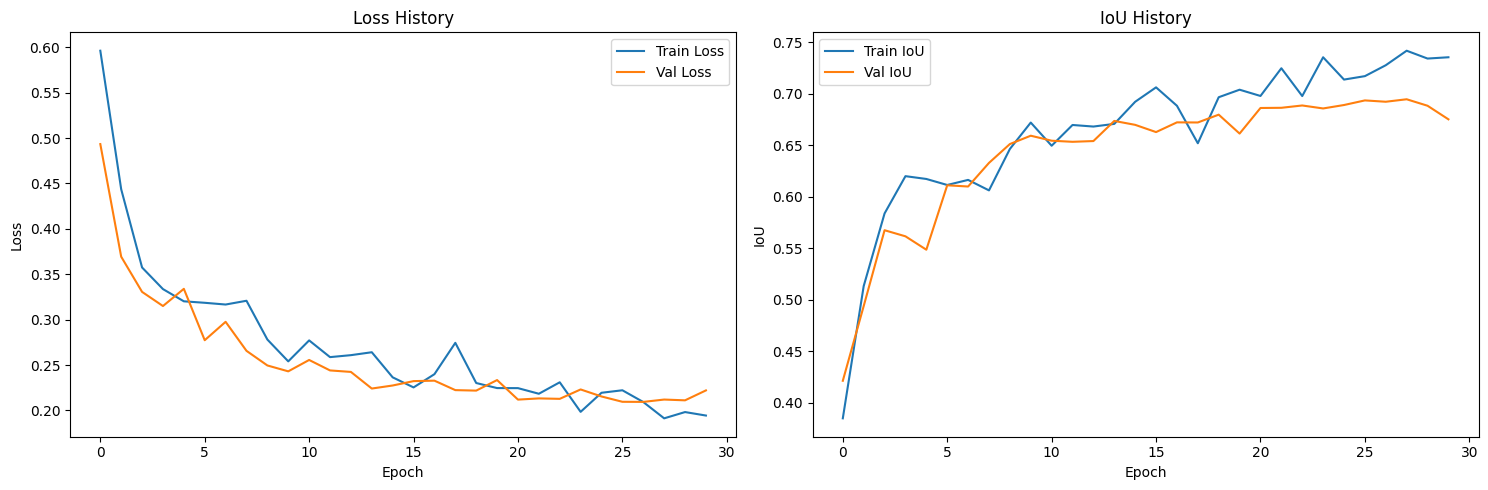

<ipython-input-6-97378a24e8a4>:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_water_segmentation_model.pth'))


Training completed!


In [6]:
# Cell 10: Define model using pretrained architecture from HuggingFace
def get_pretrained_model(num_channels=12, device=device):
    """
    Load a pretrained model from Hugging Face for semantic segmentation.
    Adapting the model to accept multispectral input with num_channels.
    """
    # Let's use a powerful segmentation model from Hugging Face
    model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
    
    try:
        # Load the feature extractor and model
        feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        model = AutoModelForSemanticSegmentation.from_pretrained(model_name)
        
        # Adapt the model for multispectral input (12 channels)
        # Get the original first conv layer
        orig_conv = model.segformer.encoder.patch_embeddings[0].proj
        
        # Create a new conv layer with the desired number of input channels
        new_conv = nn.Conv2d(
            in_channels=num_channels,
            out_channels=orig_conv.out_channels,
            kernel_size=orig_conv.kernel_size,
            stride=orig_conv.stride,
            padding=orig_conv.padding,
            bias=orig_conv.bias is not None
        )
        
        # Initialize the new weights - average the original weights across the RGB channels
        with torch.no_grad():
            new_conv.weight = nn.Parameter(
                torch.mean(orig_conv.weight, dim=1, keepdim=True).repeat(1, num_channels, 1, 1)
            )
            if orig_conv.bias is not None:
                new_conv.bias = nn.Parameter(orig_conv.bias)
        
        # Replace the original conv with our modified conv
        model.segformer.encoder.patch_embeddings[0].proj = new_conv
        
        # Adapt for binary segmentation
        # Get the classifier head
        classifier = model.decode_head.classifier
        # Replace with a new classifier for binary segmentation
        model.decode_head.classifier = nn.Conv2d(
            in_channels=classifier.in_channels,
            out_channels=1,  # Binary segmentation (water/non-water)
            kernel_size=classifier.kernel_size,
            stride=classifier.stride,
            padding=classifier.padding
        )
        
        # Move to device
        model = model.to(device)
        
        print("Successfully loaded and adapted pretrained model from Hugging Face")
        return model
    except Exception as e:
        print(f"Error loading pretrained model: {e}")
        print("Falling back to SMP UNet with pretrained encoder")
        
        # Fallback to segmentation_models_pytorch
        model = smp.Unet(
            encoder_name="efficientnet-b0",  # Use a pretrained EfficientNet backbone
            encoder_weights="imagenet",       # Use weights pretrained on ImageNet
            in_channels=num_channels,         # Number of input channels (12 for multispectral)
            classes=1,                       # Binary segmentation
            activation="sigmoid"             # Final activation function
        )
        
        model = model.to(device)
        return model

# Initialize the model
model = get_pretrained_model(num_channels=12)

# Cell 11: Define training and evaluation functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        
        # Flatten predictions and targets
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        # Calculate Dice coefficient
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        # Calculate Dice loss
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce

def calculate_metrics(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    # True Positives, False Positives, False Negatives
    tp = (pred_binary * target_binary).sum().item()
    fp = (pred_binary * (1 - target_binary)).sum().item()
    fn = ((1 - pred_binary) * target_binary).sum().item()
    tn = ((1 - pred_binary) * (1 - target_binary)).sum().item()
    
    # Calculate IoU
    iou = tp / (tp + fp + fn + 1e-8)
    
    # Calculate Precision, Recall, F1
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    return {
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }

def train_one_epoch(model, loader, optimizer, criterion, epoch, device):
    model.train()
    running_loss = 0.0
    metrics_sum = {
        'iou': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0
    }
    
    # Use tqdm for progress bar
    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Training]")
    for i, (images, masks) in enumerate(pbar):
        # Move tensors to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # Handle different model output formats
        if isinstance(outputs, dict):
            outputs = outputs.logits  # This is the case for HuggingFace models
        
        # Ensure output size matches mask size
        if outputs.shape[2:] != masks.shape[2:]:
            outputs = nn.functional.interpolate(
                outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
            )
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Calculate metrics for batch
        with torch.no_grad():
            pred = torch.sigmoid(outputs)
            batch_metrics = calculate_metrics(pred, masks)
            for k, v in batch_metrics.items():
                metrics_sum[k] += v
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (i + 1),
            'IoU': metrics_sum['iou'] / (i + 1)
        })
    
    # Calculate epoch metrics
    n_batches = len(loader)
    epoch_metrics = {k: v / n_batches for k, v in metrics_sum.items()}
    epoch_loss = running_loss / n_batches
    
    return epoch_loss, epoch_metrics

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    metrics_sum = {
        'iou': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0
    }
    
    with torch.no_grad():
        # Use tqdm for progress bar
        pbar = tqdm(loader, desc="Validation")
        for i, (images, masks) in enumerate(pbar):
            # Move tensors to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Handle different model output formats
            if isinstance(outputs, dict):
                outputs = outputs.logits  # This is the case for HuggingFace models
            
            # Ensure output size matches mask size
            if outputs.shape[2:] != masks.shape[2:]:
                outputs = nn.functional.interpolate(
                    outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
                )
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Update running loss
            running_loss += loss.item()
            
            # Calculate metrics for batch
            pred = torch.sigmoid(outputs)
            batch_metrics = calculate_metrics(pred, masks)
            for k, v in batch_metrics.items():
                metrics_sum[k] += v
            
            # Update progress bar
            pbar.set_postfix({
                'val_loss': running_loss / (i + 1),
                'val_IoU': metrics_sum['iou'] / (i + 1)
            })
    
    # Calculate validation metrics
    n_batches = len(loader)
    val_metrics = {k: v / n_batches for k, v in metrics_sum.items()}
    val_loss = running_loss / n_batches
    
    return val_loss, val_metrics

# Cell 12: Training loop
def train_model(model, train_loader, val_loader, epochs=30, patience=5, lr=1e-4):
    # Define optimizer and criterion
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = CombinedLoss(dice_weight=0.7, bce_weight=0.3)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    # Variables for early stopping
    best_iou = 0.0
    patience_counter = 0
    
    # History for plotting
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_f1': [], 'val_f1': []
    }
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_metrics = train_one_epoch(
            model, train_loader, optimizer, criterion, epoch, device
        )
        
        # Validate
        val_loss, val_metrics = validate(model, val_loader, criterion, device)
        
        # Update learning rate based on IoU
        scheduler.step(val_metrics['iou'])
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, IoU: {train_metrics['iou']:.4f}, F1: {train_metrics['f1']:.4f}")
        print(f"Val Loss: {val_loss:.4f}, IoU: {val_metrics['iou']:.4f}, F1: {val_metrics['f1']:.4f}")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_metrics['iou'])
        history['val_iou'].append(val_metrics['iou'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_f1'].append(val_metrics['f1'])
        
        # Check for improvement
        if val_metrics['iou'] > best_iou:
            best_iou = val_metrics['iou']
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_water_segmentation_model.pth')
            print(f"New best model saved with IoU: {best_iou:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs. Best IoU: {best_iou:.4f}")
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs!")
            break
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU History')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Load best model for return
    model.load_state_dict(torch.load('best_water_segmentation_model.pth'))
    
    return model, history

# Train the model
print("Starting model training...")
trained_model, history = train_model(model, train_loader, val_loader, epochs=30)
print("Training completed!")

Evaluating on test set:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Test Set Evaluation Results:
IoU: 0.4750
Precision: 0.5649
Recall: 0.5358
F1 Score: 0.5434
Accuracy: 0.9495


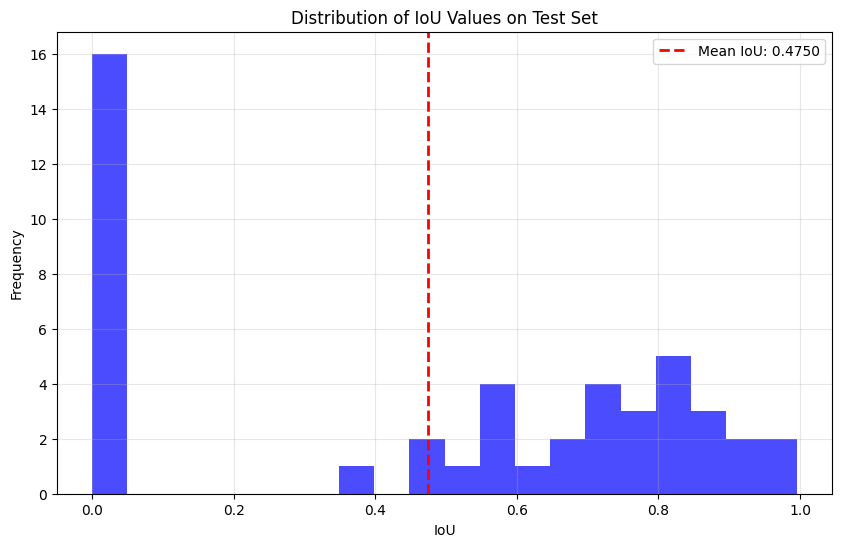

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


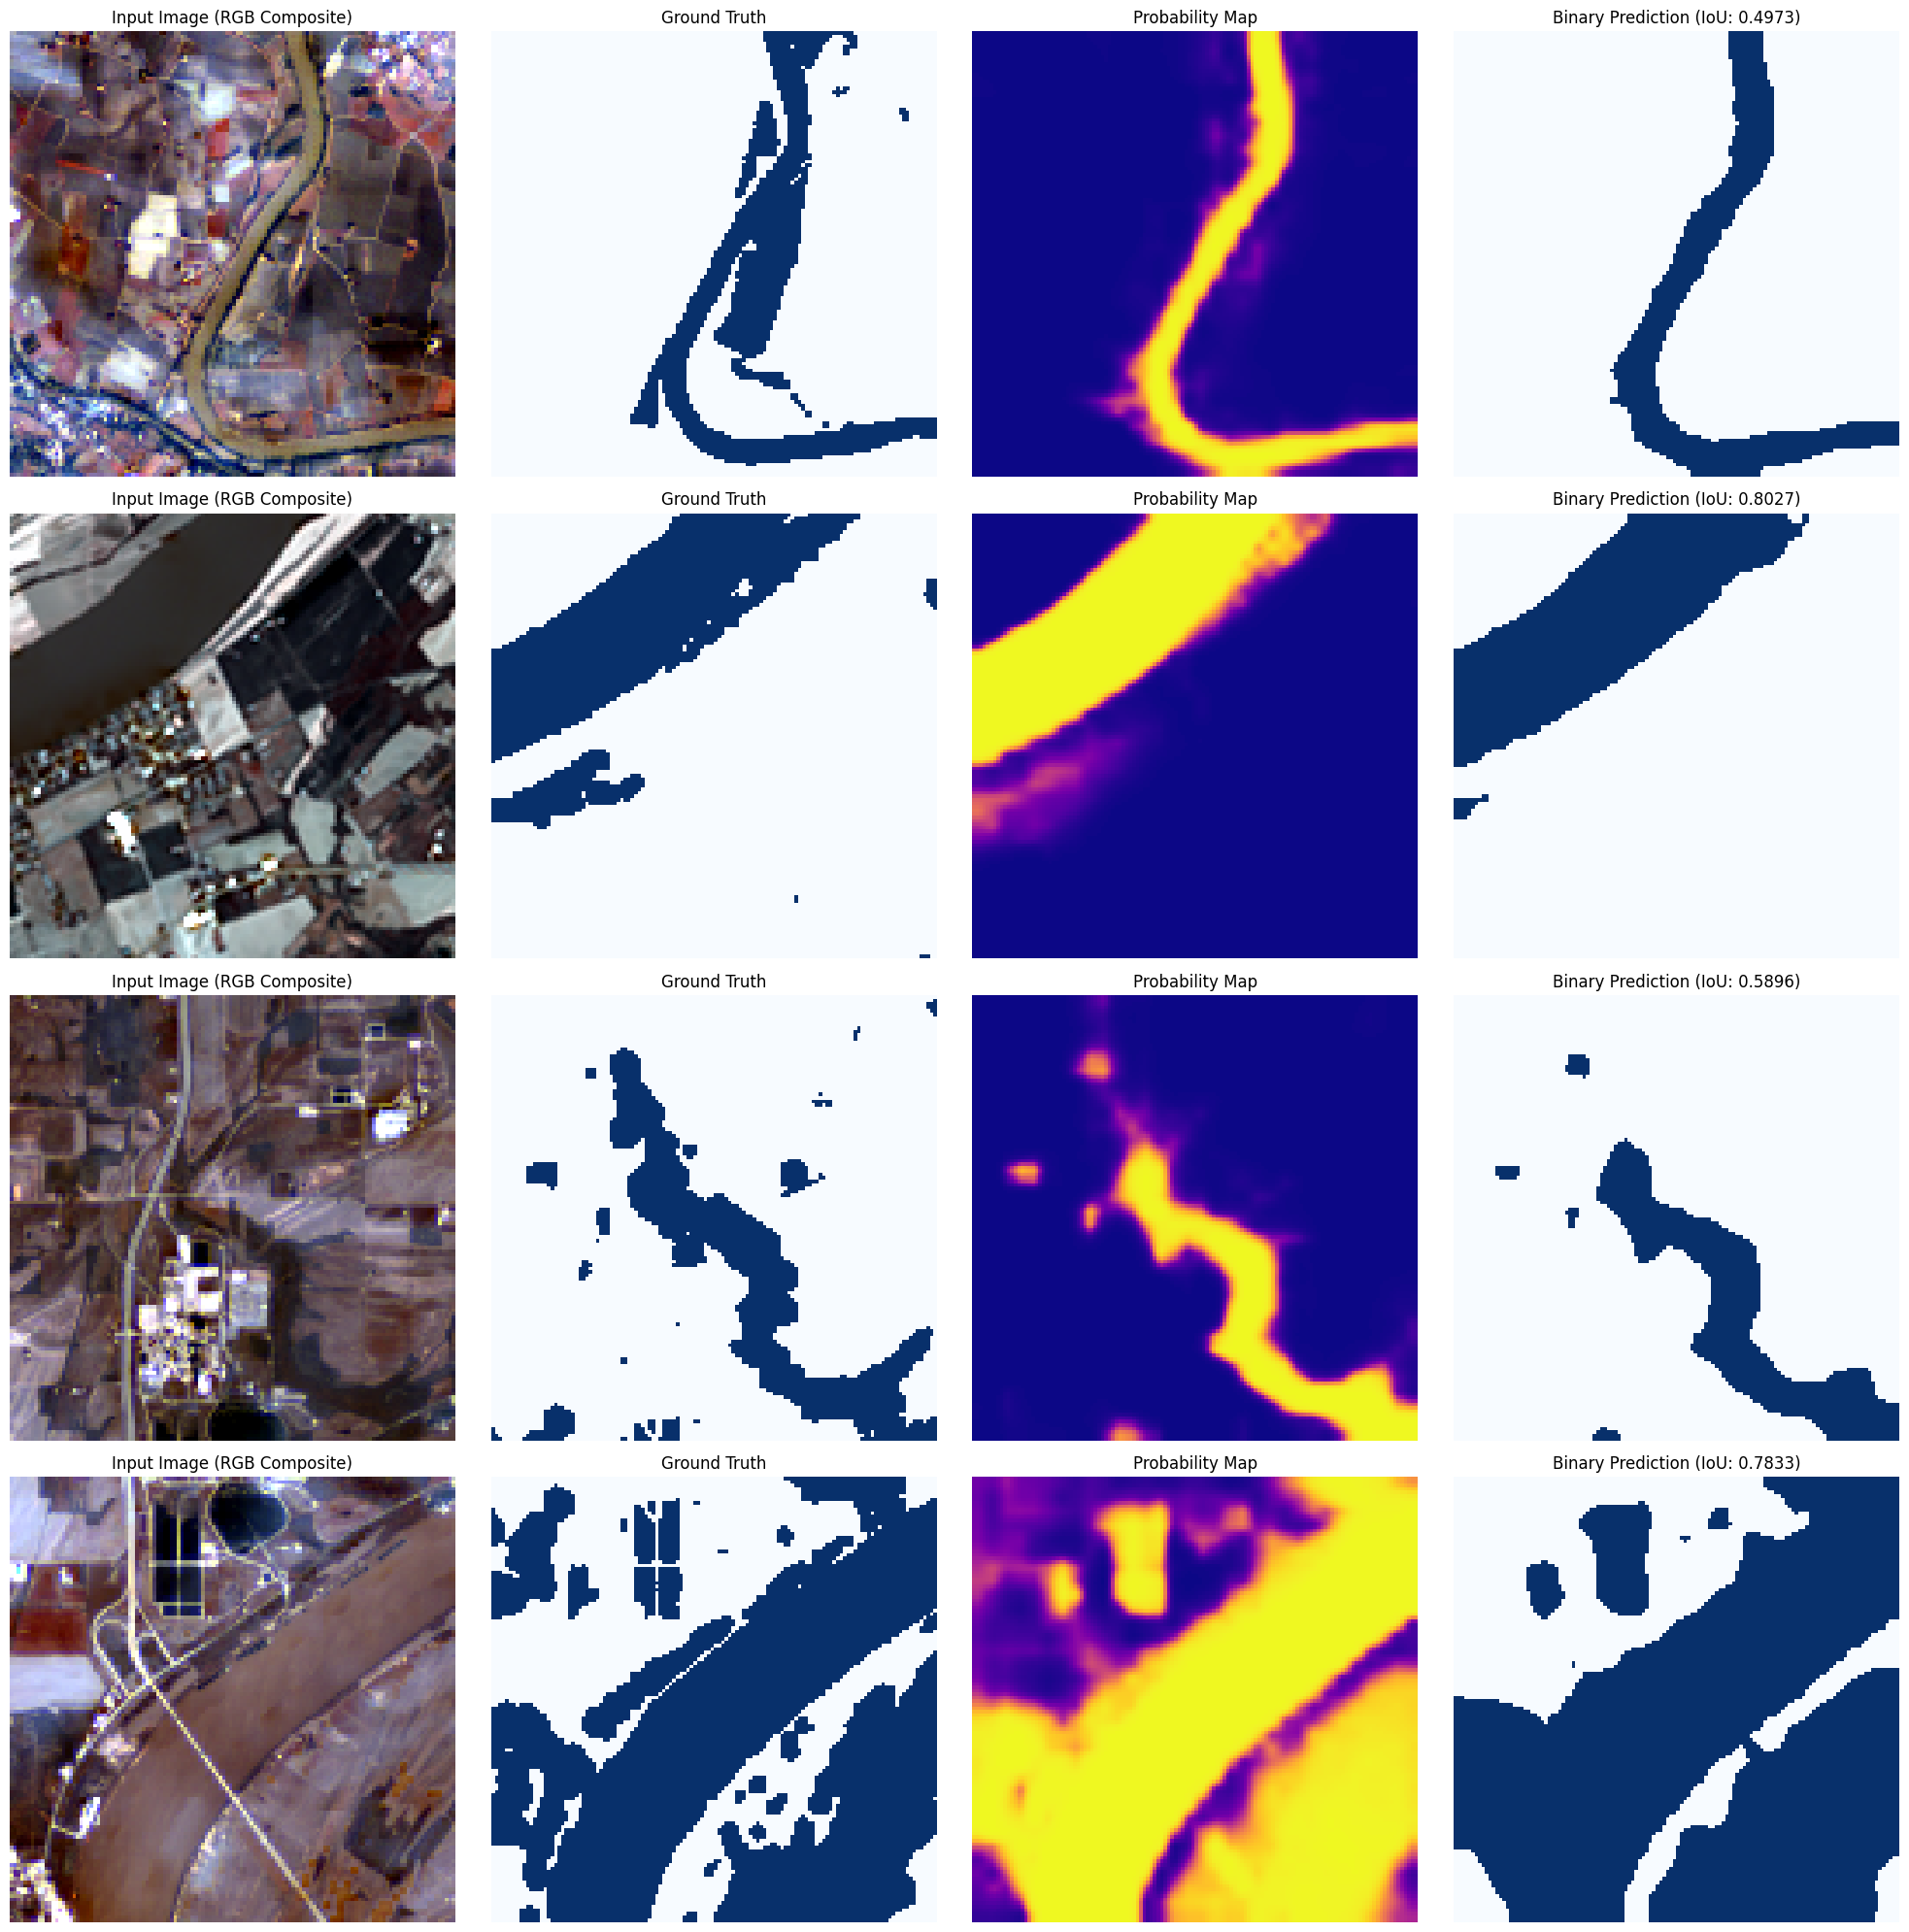

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


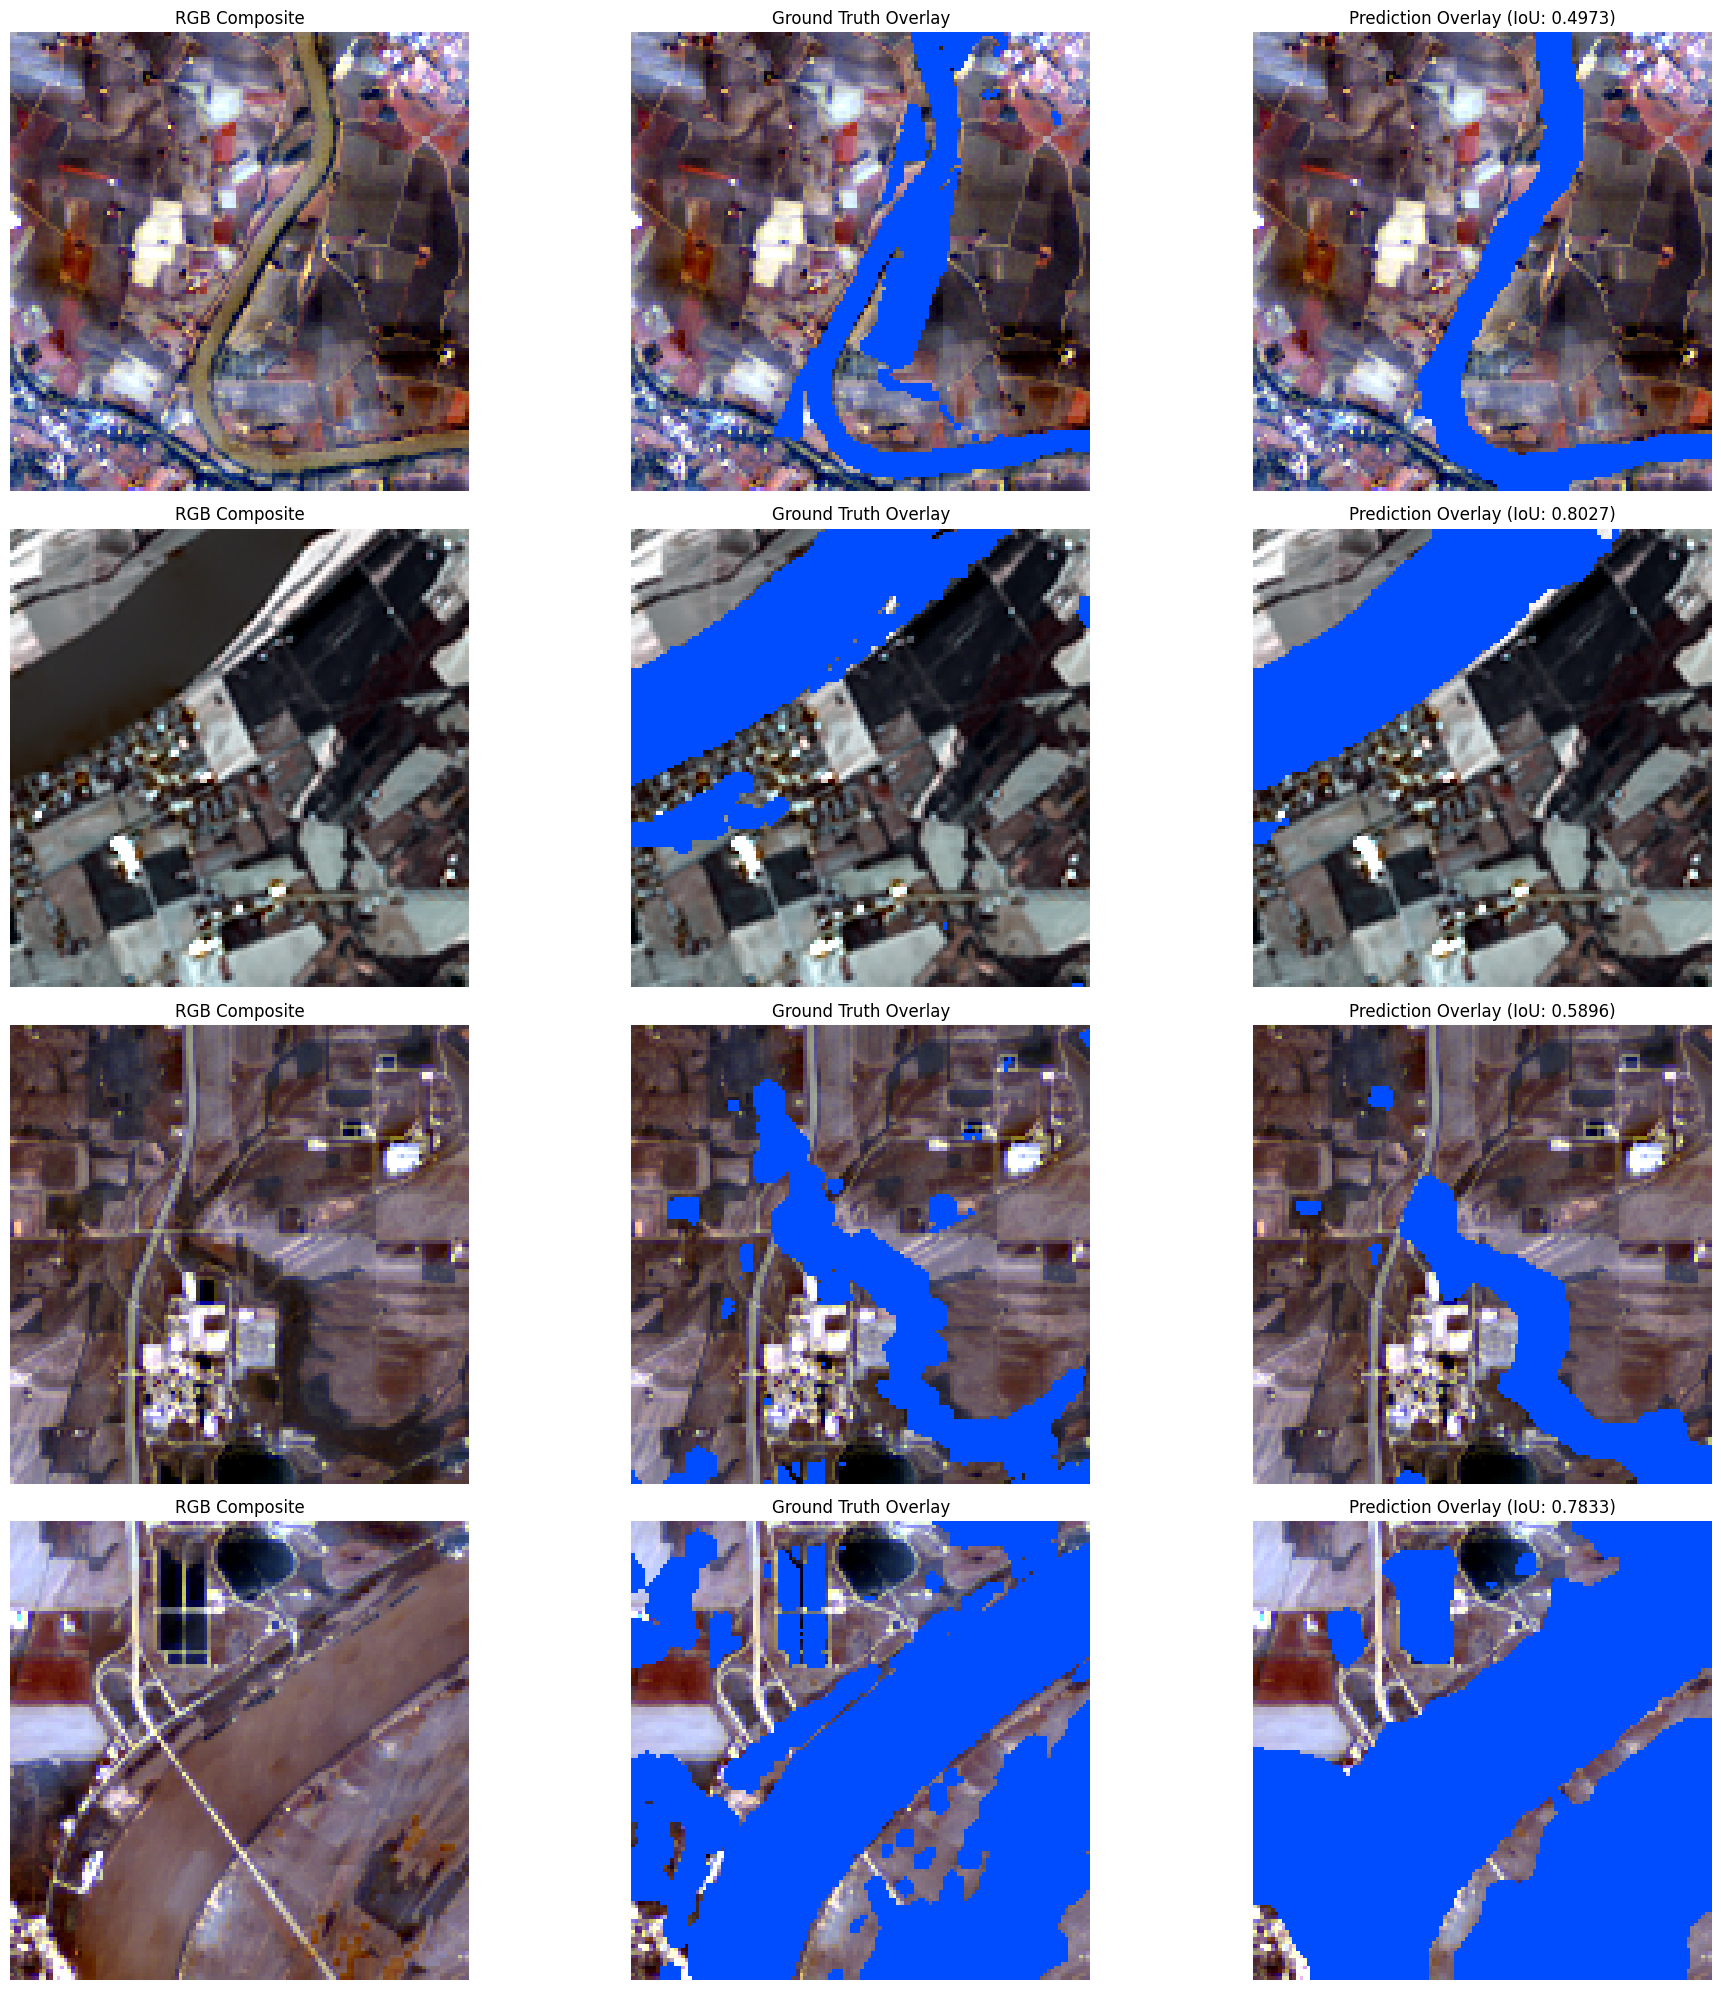

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


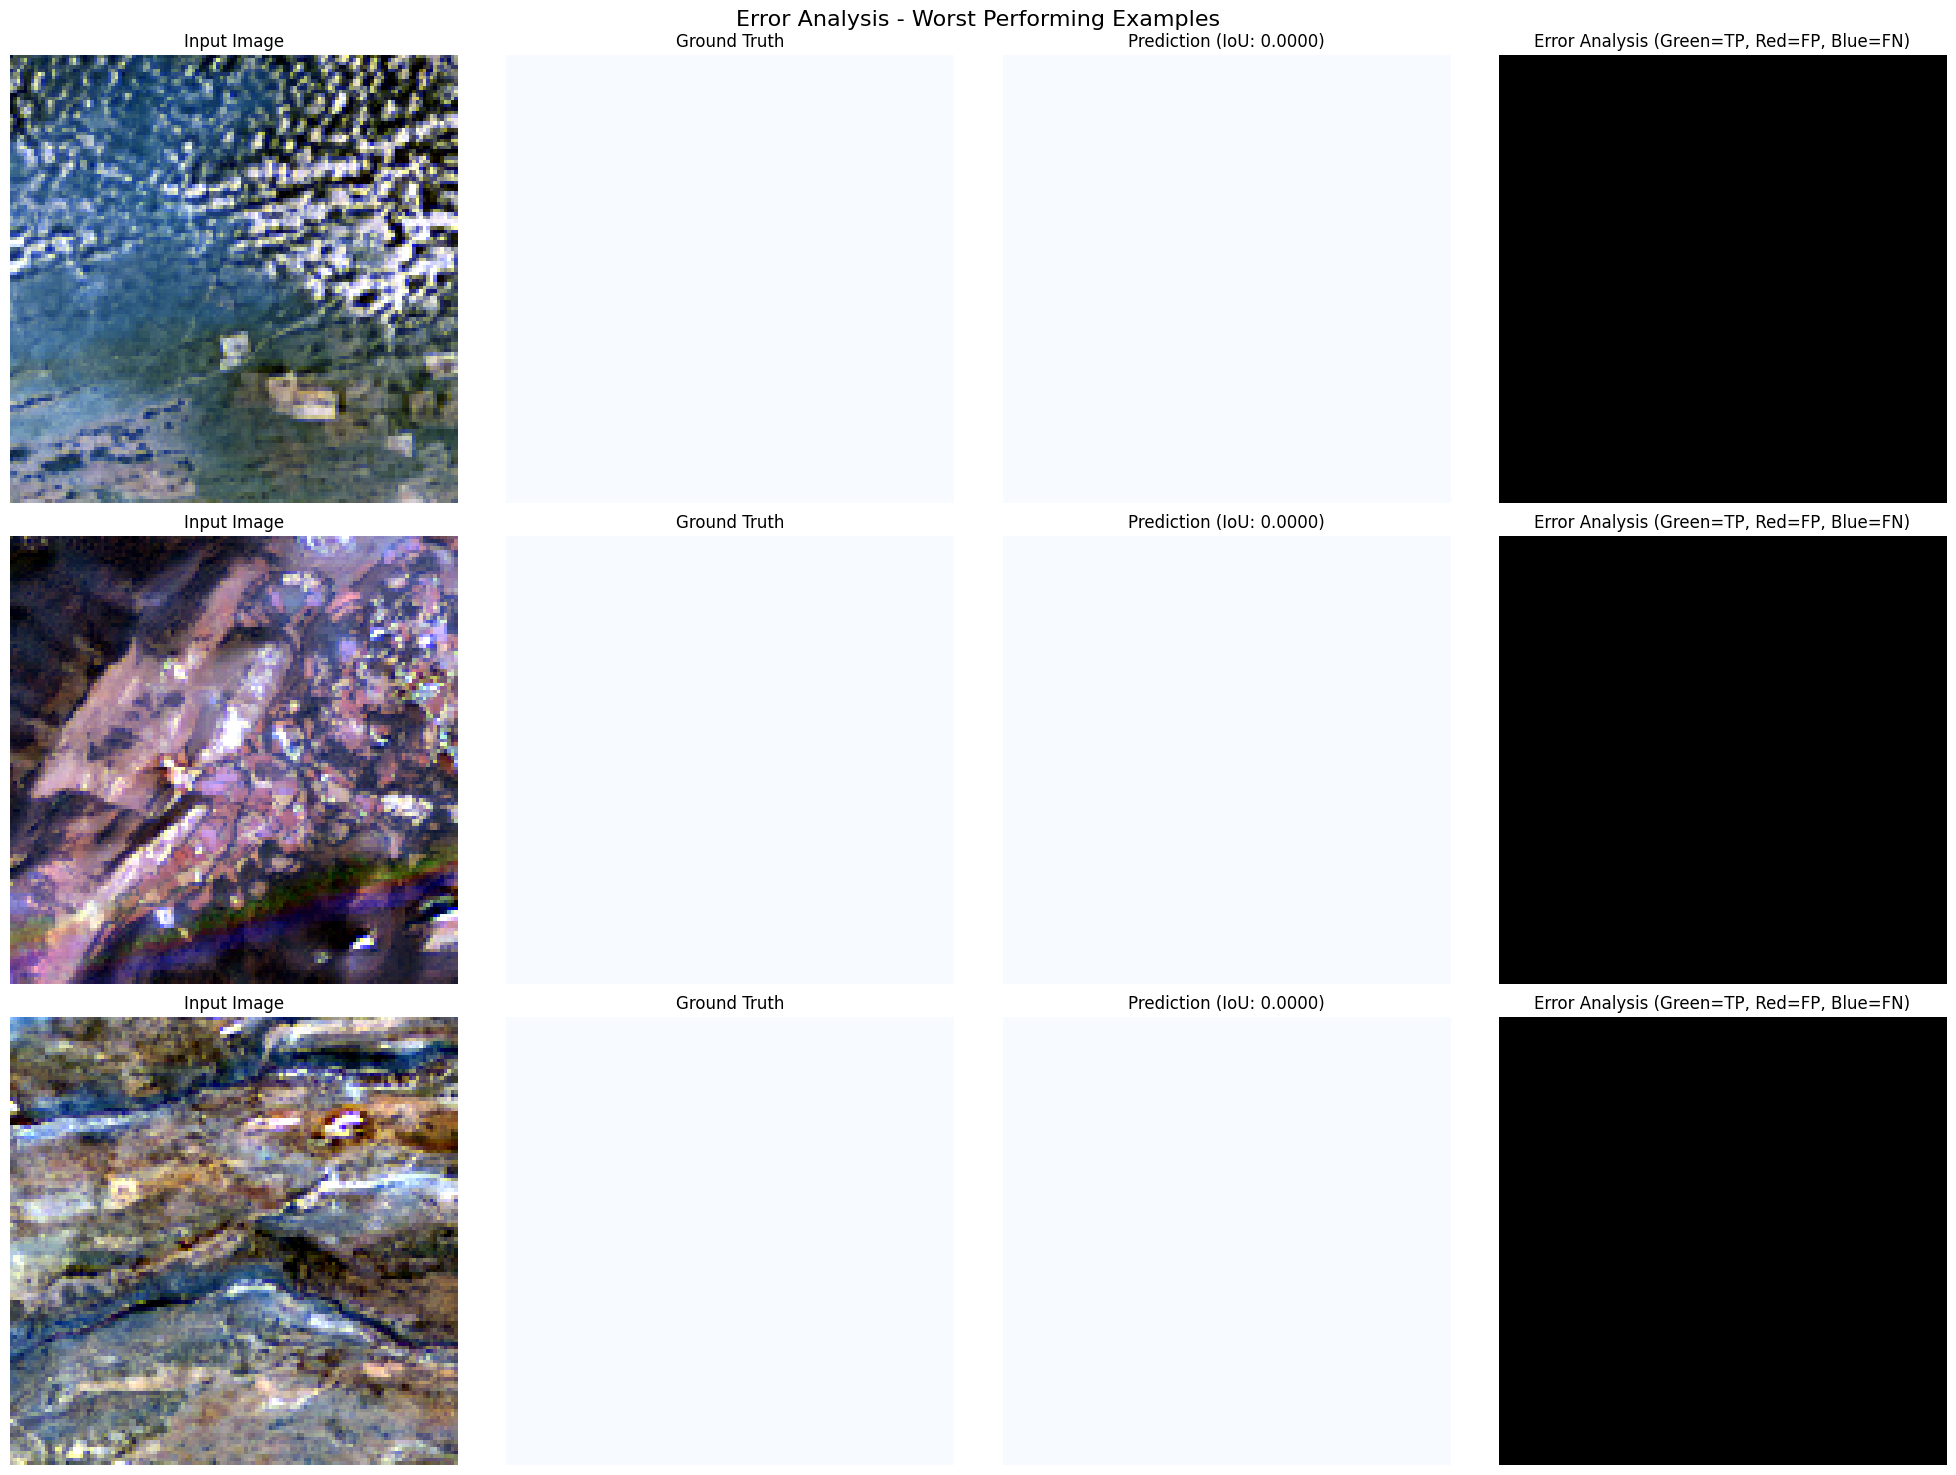

In [7]:
# Cell 13: Evaluate model on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    all_metrics = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on test set"):
            # Move tensors to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Handle different model output formats
            if isinstance(outputs, dict):
                outputs = outputs.logits
            
            # Ensure output size matches mask size
            if outputs.shape[2:] != masks.shape[2:]:
                outputs = nn.functional.interpolate(
                    outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
                )
            
            # Calculate metrics for each image in batch
            pred = torch.sigmoid(outputs)
            
            for i in range(images.shape[0]):
                metrics = calculate_metrics(pred[i:i+1], masks[i:i+1])
                all_metrics.append(metrics)
    
    # Calculate average metrics
    avg_metrics = {
        'iou': np.mean([m['iou'] for m in all_metrics]),
        'precision': np.mean([m['precision'] for m in all_metrics]),
        'recall': np.mean([m['recall'] for m in all_metrics]),
        'f1': np.mean([m['f1'] for m in all_metrics]),
        'accuracy': np.mean([m['accuracy'] for m in all_metrics])
    }
    
    # Print results
    print("\nTest Set Evaluation Results:")
    print(f"IoU: {avg_metrics['iou']:.4f}")
    print(f"Precision: {avg_metrics['precision']:.4f}")
    print(f"Recall: {avg_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
    
    # Calculate per-image metrics for analysis
    iou_values = [m['iou'] for m in all_metrics]
    
    # Plot histogram of IoU values
    plt.figure(figsize=(10, 6))
    plt.hist(iou_values, bins=20, alpha=0.7, color='blue')
    plt.axvline(avg_metrics['iou'], color='red', linestyle='dashed', linewidth=2, label=f'Mean IoU: {avg_metrics["iou"]:.4f}')
    plt.title('Distribution of IoU Values on Test Set')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return avg_metrics, all_metrics

# Evaluate the model
test_metrics, per_image_metrics = evaluate_model(trained_model, test_loader, device)

# Cell 14: Visualize predictions on test set
def visualize_predictions(model, test_loader, num_samples=5, device=device):
    model.eval()
    
    # Get a batch from the test loader
    images, masks = next(iter(test_loader))
    
    # Ensure we don't try to visualize more than we have
    num_samples = min(num_samples, images.shape[0])
    
    # Generate predictions
    with torch.no_grad():
        images_device = images[:num_samples].to(device)
        outputs = model(images_device)
        
        # Handle different model output formats
        if isinstance(outputs, dict):
            outputs = outputs.logits
        
        # Ensure output size matches mask size
        if outputs.shape[2:] != masks.shape[2:]:
            outputs = nn.functional.interpolate(
                outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
            )
        
        predictions = torch.sigmoid(outputs).cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i in range(num_samples):
        # Get image, mask, and prediction
        image = images[i].numpy()
        mask = masks[i].numpy()
        pred = predictions[i]
        
        # Create RGB composite for visualization
        rgb = np.zeros((image.shape[1], image.shape[2], 3))
        rgb[:,:,0] = np.clip(image[2], 0, 1)  # Adjust these indices based on your band arrangement
        rgb[:,:,1] = np.clip(image[1], 0, 1)
        rgb[:,:,2] = np.clip(image[0], 0, 1)
        
        # Binary prediction mask (threshold at 0.5)
        pred_binary = (pred > 0.5).astype(np.float32)
        
        # Plot RGB image
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title('Input Image (RGB Composite)')
        axes[i, 0].axis('off')
        
        # Plot ground truth mask
        axes[i, 1].imshow(mask[0], cmap='Blues')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Plot prediction probability map
        axes[i, 2].imshow(pred[0], cmap='plasma')
        axes[i, 2].set_title('Probability Map')
        axes[i, 2].axis('off')
        
        # Plot binary prediction
        axes[i, 3].imshow(pred_binary[0], cmap='Blues')
        
        # Calculate IoU for this sample
        tp = np.sum((pred_binary[0] == 1) & (mask[0] == 1))
        fp = np.sum((pred_binary[0] == 1) & (mask[0] == 0))
        fn = np.sum((pred_binary[0] == 0) & (mask[0] == 1))
        iou = tp / (tp + fp + fn + 1e-8)
        
        axes[i, 3].set_title(f'Binary Prediction (IoU: {iou:.4f})')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(trained_model, test_loader, num_samples=5)

# Cell 15: Visualize prediction overlays
def visualize_prediction_overlays(model, test_loader, num_samples=5, device=device):
    model.eval()
    
    # Get a batch from the test loader
    dataiter = iter(test_loader)
    images, masks = next(dataiter)
    
    # Ensure we don't try to visualize more than we have
    num_samples = min(num_samples, images.shape[0])
    
    # Generate predictions
    with torch.no_grad():
        images_device = images[:num_samples].to(device)
        outputs = model(images_device)
        
        # Handle different model output formats
        if isinstance(outputs, dict):
            outputs = outputs.logits
        
        # Ensure output size matches mask size
        if outputs.shape[2:] != masks.shape[2:]:
            outputs = nn.functional.interpolate(
                outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
            )
        
        predictions = torch.sigmoid(outputs).cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5*num_samples))
    
    for i in range(num_samples):
        # Get image, mask, and prediction
        image = images[i].numpy()
        mask = masks[i].numpy()
        pred = predictions[i]
        
        # Create RGB composite for visualization
        rgb = np.zeros((image.shape[1], image.shape[2], 3))
        rgb[:,:,0] = np.clip(image[2], 0, 1)  # Adjust based on your band arrangement
        rgb[:,:,1] = np.clip(image[1], 0, 1)
        rgb[:,:,2] = np.clip(image[0], 0, 1)
        
        # Binary prediction mask (threshold at 0.5)
        pred_binary = (pred[0] > 0.5).astype(np.float32)
        
        # Create overlays
        # Ground truth overlay (water in blue)
        gt_overlay = rgb.copy()
        gt_water = mask[0] > 0.5
        gt_overlay[gt_water, 0] = 0.0  # Reduce red
        gt_overlay[gt_water, 1] = 0.3  # Reduce green
        gt_overlay[gt_water, 2] = 1.0  # Enhance blue
        
        # Prediction overlay
        pred_overlay = rgb.copy()
        pred_water = pred_binary > 0.5
        pred_overlay[pred_water, 0] = 0.0  # Reduce red
        pred_overlay[pred_water, 1] = 0.3  # Reduce green
        pred_overlay[pred_water, 2] = 1.0  # Enhance blue
        
        # Plot overlays
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title('RGB Composite')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title('Ground Truth Overlay')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_overlay)
        # Calculate IoU for this sample
        tp = np.sum((pred_binary == 1) & (mask[0] > 0.5))
        fp = np.sum((pred_binary == 1) & (mask[0] <= 0.5))
        fn = np.sum((pred_binary == 0) & (mask[0] > 0.5))
        iou = tp / (tp + fp + fn + 1e-8)
        
        axes[i, 2].set_title(f'Prediction Overlay (IoU: {iou:.4f})')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize prediction overlays
visualize_prediction_overlays(trained_model, test_loader, num_samples=5)

# Cell 16: Error analysis - Visualize false positives and false negatives
def visualize_error_analysis(model, test_loader, num_samples=3, device=device):
    model.eval()
    
    all_images = []
    all_masks = []
    all_preds = []
    all_ious = []
    
    # Generate predictions for multiple batches
    with torch.no_grad():
        for images, masks in test_loader:
            # Forward pass
            images_device = images.to(device)
            outputs = model(images_device)
            
            # Handle different model output formats
            if isinstance(outputs, dict):
                outputs = outputs.logits
            
            # Ensure output size matches mask size
            if outputs.shape[2:] != masks.shape[2:]:
                outputs = nn.functional.interpolate(
                    outputs, size=masks.shape[2:], mode='bilinear', align_corners=False
                )
            
            # Get predictions
            preds = torch.sigmoid(outputs).cpu().numpy()
            
            # Save data
            all_images.append(images.numpy())
            all_masks.append(masks.numpy())
            all_preds.append(preds)
            
            # Calculate IoU for each sample
            for i in range(images.shape[0]):
                pred_binary = (preds[i, 0] > 0.5).astype(np.float32)
                mask = masks[i, 0].numpy()
                
                tp = np.sum((pred_binary == 1) & (mask == 1))
                fp = np.sum((pred_binary == 1) & (mask == 0))
                fn = np.sum((pred_binary == 0) & (mask == 1))
                iou = tp / (tp + fp + fn + 1e-8)
                
                all_ious.append(iou)
            
            # Only process a few batches
            if len(all_ious) >= 20:
                break
    
    # Convert to numpy arrays
    all_images = np.vstack(all_images)
    all_masks = np.vstack(all_masks)
    all_preds = np.vstack(all_preds)
    all_ious = np.array(all_ious)
    
    # Find worst IoU examples
    worst_indices = np.argsort(all_ious)[:num_samples]
    
    # Create figure for error analysis
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i, idx in enumerate(worst_indices):
        # Get image, mask, and prediction
        image = all_images[idx]
        mask = all_masks[idx, 0]
        pred = all_preds[idx, 0]
        pred_binary = (pred > 0.5).astype(np.float32)
        
        # Create RGB composite
        rgb = np.zeros((image.shape[1], image.shape[2], 3))
        rgb[:,:,0] = np.clip(image[2], 0, 1)
        rgb[:,:,1] = np.clip(image[1], 0, 1)
        rgb[:,:,2] = np.clip(image[0], 0, 1)
        
        # False positive mask (prediction=1, ground truth=0)
        false_pos = (pred_binary == 1) & (mask == 0)
        
        # False negative mask (prediction=0, ground truth=1)
        false_neg = (pred_binary == 0) & (mask == 1)
        
        # True positive mask (prediction=1, ground truth=1)
        true_pos = (pred_binary == 1) & (mask == 1)
        
        # Create error visualization
        error_viz = np.zeros((image.shape[1], image.shape[2], 3))
        error_viz[true_pos, 1] = 1.0  # True positives in green
        error_viz[false_pos, 0] = 1.0  # False positives in red
        error_viz[false_neg, 2] = 1.0  # False negatives in blue
        
        # Plot
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='Blues')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_binary, cmap='Blues')
        axes[i, 2].set_title(f'Prediction (IoU: {all_ious[idx]:.4f})')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(error_viz)
        axes[i, 3].set_title('Error Analysis (Green=TP, Red=FP, Blue=FN)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Error Analysis - Worst Performing Examples', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize error analysis
visualize_error_analysis(trained_model, test_loader, num_samples=3)